# 투빅스 Week2 Regression_과제3 - 16기 김주호

1. sklearn 패키지를 사용해 로지스틱 회귀모형으로 데이터를 분석해 주세요 
2. 성능지표를 계산하고 이에 대해 해석해 주세요 
   - sklearn : mean accuracy, f1 score 등 다양한 성능지표 계산 
   - confusion matrix : tp, fp, fn, tn 값을 통해 성능지표 계산  
3. 어떤 성능지표를 기준으로 성능을 개선을 시도했고, 그러한 선택의 이유를 적어주세요.
4. **해석을 상세하게 달아주세요 !**

## Data & EDA

출처 : https://www.kaggle.com/mlg-ulb/creditcardfraud


* V1 ~ V28 : 비식별화 된 개인정보 
* **Class** : Target 변수  
  - 1 : fraudulent transactions (사기)
  - 0 : otherwise 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv("C:/tobigs_data/2주차 데이터/assignment3_creditcard.csv")

In [3]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.848212,2.384900,0.379573,1.048381,-0.845070,2.537837,-4.542983,-10.201458,-1.504967,-2.234167,...,2.585817,-5.291690,0.859364,0.423231,-0.506985,1.020052,-0.627751,-0.017753,0.280982,0
1,2.071805,-0.477943,-1.444444,-0.548657,0.010036,-0.582242,-0.042878,-0.247160,1.171923,-0.342382,...,-0.077306,0.042858,0.390125,0.041569,0.598427,0.098803,0.979686,-0.093244,-0.065615,0
2,-2.985294,-2.747472,1.194068,-0.003036,-1.151041,-0.263559,0.553500,0.635600,0.438545,-1.806488,...,1.345776,0.373760,-0.385777,1.197596,0.407229,0.008013,0.762362,-0.299024,-0.303929,0
3,-1.479452,1.542874,0.290895,0.838142,-0.529290,-0.717661,0.484516,0.545092,-0.780767,0.324804,...,0.038397,0.116771,0.405560,-0.116453,0.541275,-0.216665,-0.415578,0.027126,-0.150347,0
4,-0.281976,-0.309699,-2.162299,-0.851514,0.106167,-1.483888,1.930994,-0.843049,-1.249272,1.079608,...,-0.875516,-0.004199,1.015108,-0.026748,0.077115,-1.468822,0.751700,0.496732,0.331001,0


In [4]:
print(data.shape)
print('총 결측치의 수:', data.isnull().sum().sum())
data.info()

(28678, 29)
총 결측치의 수: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28678 entries, 0 to 28677
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      28678 non-null  float64
 1   V2      28678 non-null  float64
 2   V3      28678 non-null  float64
 3   V4      28678 non-null  float64
 4   V5      28678 non-null  float64
 5   V6      28678 non-null  float64
 6   V7      28678 non-null  float64
 7   V8      28678 non-null  float64
 8   V9      28678 non-null  float64
 9   V10     28678 non-null  float64
 10  V11     28678 non-null  float64
 11  V12     28678 non-null  float64
 12  V13     28678 non-null  float64
 13  V14     28678 non-null  float64
 14  V15     28678 non-null  float64
 15  V16     28678 non-null  float64
 16  V17     28678 non-null  float64
 17  V18     28678 non-null  float64
 18  V19     28678 non-null  float64
 19  V20     28678 non-null  float64
 20  V21     28678 non-null  float64
 21  V22     286

타겟값 이외에는 모두 실수형이며 결측치는 없음을 확인할 수 있다

In [5]:
print('전체에서 타겟값이 0인 비율')
print(round((len(data[data['Class']==0]['Class'])/data.shape[0])*100,2),"%",'\n')

print('전체에서 타겟값이 1인 비율')
print(round((len(data[data['Class']==1]['Class'])/data.shape[0])*100,2),"%")

전체에서 타겟값이 0인 비율
99.14 % 

전체에서 타겟값이 1인 비율
0.86 %


사기에 해당하는 타겟값의 비율이 매우 적어 타겟값 **데이터가 매우 불균형**하게 치우쳐있음을 알 수 있다. 타겟값이 연속형 변수가 아니기에 로그변환을 통해 정규화를 시킬 수도 없다. 따라서 데이터를 일차적으로 학습 및 예측한 후, 성능 개선을 위해 **SMOTE 오버샘플링**을 통해 사기(Class=1)에 해당하는 데이터를 증식시켜 이전의 성능과 비교해보도록 한다.

- 우선, 데이터를 훈련용, 테스트용 데이터 셋으로 나누어 학습 및 예측을 진행한다

In [6]:
from sklearn.model_selection import train_test_split

# 피처 데이터와 타겟 데이터로 분리
X_features=data.iloc[:,:-1]
y_target=data.iloc[:,-1]

# 훈련 및 검증 데이터셋으로 분리
## stratify 옵션을 통해 타겟값의 비율을 맞춰주기
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

In [7]:
# 고르게 분포되었음을 확인할 수 있음!
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100,'\n')

print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.14317
1     0.85683
Name: Class, dtype: float64 

테스트 데이터 레이블 값 비율
0    99.139935
1     0.860065
Name: Class, dtype: float64


## 로지스틱 회귀분석으로 학습 및 예측 수행

#### 오차행렬과 정확도, 정밀도, 재현율, F1-score, ROC-AUC 지표를 함께 출력하는 함수 만들기

In [8]:
def eval_index(y_test,pred=None,pred_proba=None):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)
    roc_auc=roc_auc_score(y_test,pred)
    print('오차행렬')
    print(confusion,'\n')
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [9]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
lr_pred_proba=lr.predict_proba(X_test)[:,1]

eval_index(y_test,lr_pred,lr_pred_proba)

오차행렬
[[8527    3]
 [  15   59]] 

정확도: 0.9979, 정밀도: 0.9516, 재현율: 0.7973, F1: 0.8676, AUC: 0.8985


신용카드 사기 적발 예측 모델은 음성인 데이터를 양성이라고 잘못 예측하는 것보다 **양성인 데이터를 음성이라고 예측**하는게 **훨씬 심각한 피해**를 가져다 줄 수 있다. 


따라서, 위 모델은 상대적으로 **재현율이 더 중요**한 지표이다. FN을 줄이되 f1, auc 지표가 너무 낮아지지 않도록 하는 것이 관건으로 볼 수 있다.

변수의 분포를 확인하여 치우친 변수에 대해서는 **로그변환을 통해 정규화**를 시도하고, 히트맵으로 변수간 상관관계를 파악하여 높은 상관성을 가지는 열을 기준으로 **이상치를 제거**한 후, 성능의 차이를 비교한다.

### 변수별 분포 확인

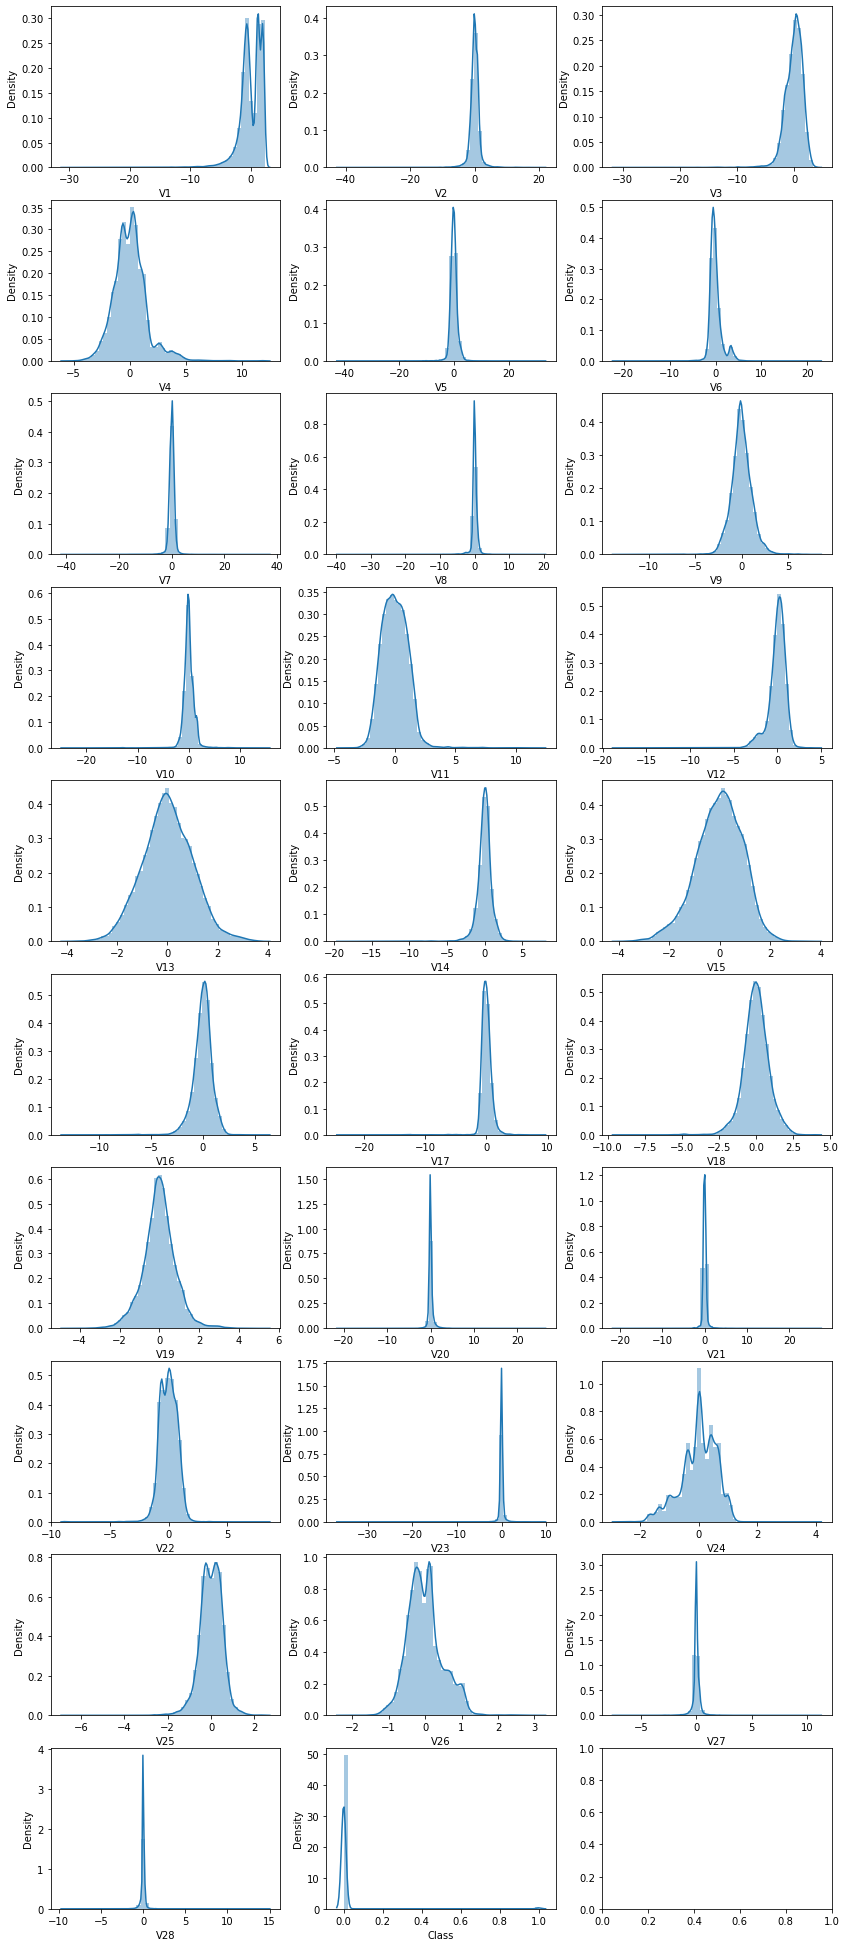

In [10]:
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(14,35),nrows=10,ncols=3)

ax = ax.flatten()

for i,col in enumerate(data.columns):
    sns.distplot(data[col],ax=ax[i])
plt.show()

대부분의 변수가 잘모여있는 것을 확인할 수 있고, 긴꼬리 형태가 많은 것으로 보아 이상치 제거가 필요해보인다

### 변수간 상관관계 시각화

<AxesSubplot:>

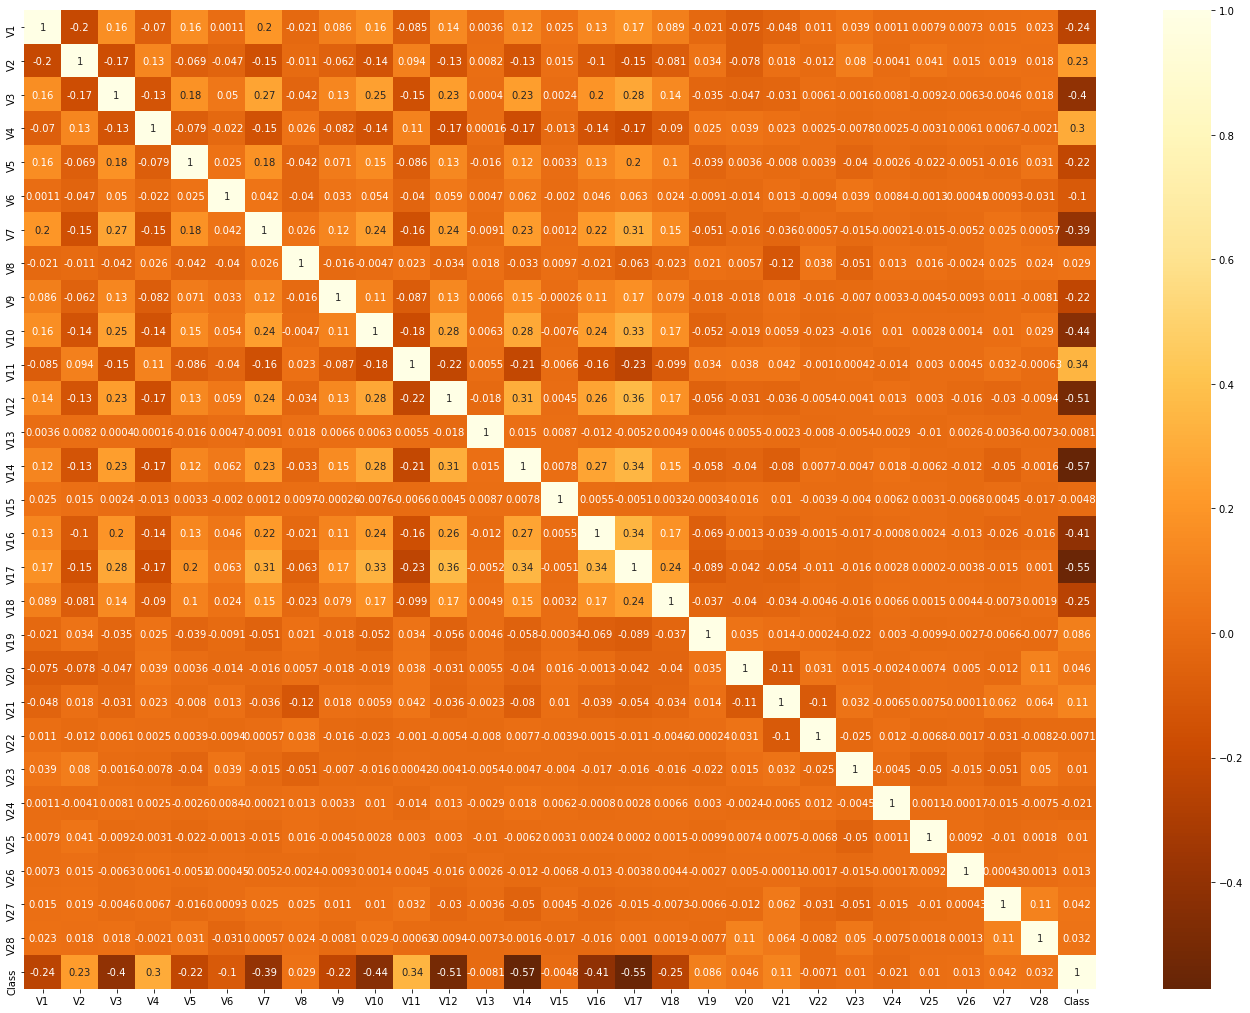

In [11]:
import seaborn as sns
plt.figure(figsize=(24,18))
corr=data.corr()
sns.heatmap(corr,cmap='YlOrBr_r',annot=True)

V12, V14, V17이 타겟변수와 -0.5이상의 강한 음의 상관이 있음을 확인할 수 있다.

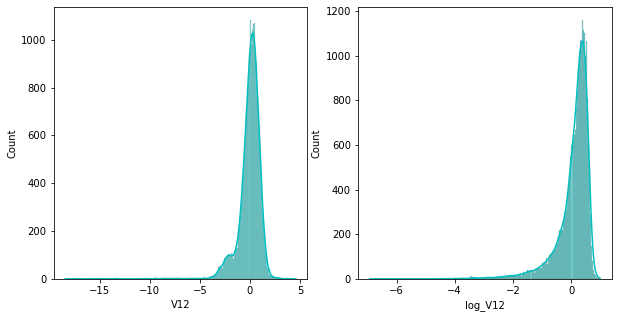

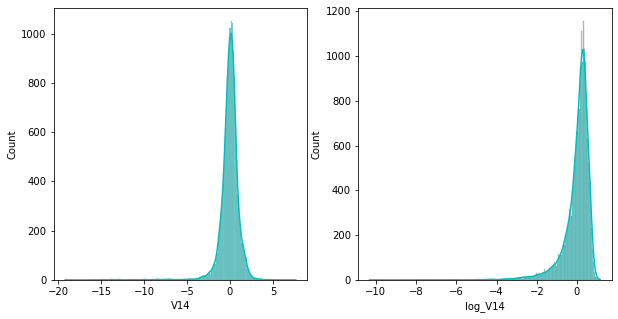

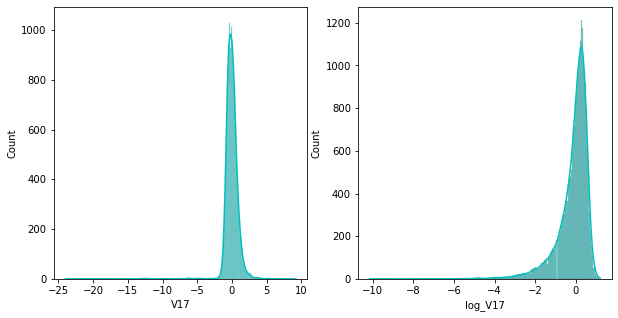

In [12]:
data_1=data.copy()
col_list=['V12','V14','V17']
for col in col_list:
    data_1['log_'+col]=np.log1p(data_1[col]) # 0을 가진 변수도 로그변환이 가능하도록 log1p()사용
    f,axes=plt.subplots(ncols=2,figsize=(10,5))
    sns.histplot(data[col],ax=axes[0],color='c',kde=True,)
    sns.histplot(np.log1p(data_1['log_'+col]), ax=axes[1],color='c',kde=True)
    plt.show()

상관성이 높은 열 위주로 로그변환을 시도했으나 긴꼬리 형태는 유지되고 오히려 치우쳐진 느낌이 있어 로그변환은 생략하는 것이 나아보인다.

### 이상치 제거

- 음의 상관도가 높은 위 세개의 지표는 낮을 수록 사기 데이터가 많다는 것이다.
- 따라서, **일반 거래 중 위 지표가 낮은 경우**와 **사기 거래 중 위 지표가 높은 경우**의 이상치를 제거하면 성능이 많이 좋아질 것이라고 예상할 수 있다.

In [10]:
# 타겟값이 0인 데이터 중 이상치에 해당하는 행 인덱스 추출하는 함수
import numpy as np
def get_outlier0(df=data,column=None,weight=1.5):
    not_fraud=df[df['Class']==0][column]
    quan_25=np.percentile(not_fraud.values,25)
    quan_75=np.percentile(not_fraud.values,75)
    iqr=quan_75-quan_25
    iqr_weight=iqr*weight
    lowest=quan_25-iqr_weight
    outlier_index=not_fraud[not_fraud<lowest].index
    return outlier_index

- 일반 거래 중 위 지표가 1.5*IQR보다 낮은 인덱스를 상관성이 높은 열 3개에서 구한 후, 교집합에 해당하는 index를 뽑아냄

In [11]:
outlier_index_12=get_outlier0(df=data, column='V12', weight=1.5)
outlier_index_14=get_outlier0(df=data, column='V14', weight=1.5)
outlier_index_17=get_outlier0(df=data, column='V17', weight=1.5)
v12_out_index0=set(outlier_index_12)
v14_out_index0=set(outlier_index_14)
v17_out_index0=set(outlier_index_17)

outlier_index0=v12_out_index0&v14_out_index0&v17_out_index0

In [12]:
# 타겟값이 1인 데이터 중 이상치에 해당하는 행 인덱스 추출하는 함수
def get_outlier1(df=data,column=None,weight=1.5):
    fraud=df[df['Class']==1][column]
    quan_25=np.percentile(fraud.values,25)
    quan_75=np.percentile(fraud.values,75)
    iqr=quan_75-quan_25
    iqr_weight=iqr*weight
    highest=quan_25+iqr_weight
    outlier_index=fraud[fraud>highest].index
    return outlier_index

In [13]:
outlier_index_12=get_outlier1(df=data, column='V12', weight=1.5)
outlier_index_14=get_outlier1(df=data, column='V14', weight=1.5)
outlier_index_17=get_outlier1(df=data, column='V17', weight=1.5)
v12_out_index1=set(outlier_index_12)
v14_out_index1=set(outlier_index_14)
v17_out_index1=set(outlier_index_17)

- outlier_index1=(v12_out_index1&v14_out_index1)|(v12_out_index1&v17_out_index1) : 16개의 이상치 데이터
- outlier_index1=(v12_out_index1&v14_out_index1) : 13개 이상치 데이터
- outlier_index1=(v12_out_index1&v17_out_index1) : 3개 이상치 데이터
- outlier_index1=(v14_out_index1&v17_out_index1) : 교집합 없음 => 세개의 열에 대한 교집합 또한 없음

In [14]:
# 사기 데이터 중 V12,V14,V17 각 열의 이상치 데이터의 교집합에서 원소의 수를 구함.
print(len((v12_out_index1&v14_out_index1)|(v12_out_index1&v17_out_index1)))
print(len((v12_out_index1&v14_out_index1)))
print(len((v12_out_index1&v17_out_index1)))
print(len((v14_out_index1&v17_out_index1)))

16
13
3
0


따라서, 타겟값이 0인 데이터 중 세 개의 열에서 1.5*IQR보다 낮은 행 데이터는 총 11개이고,

타겟값이 1인 데이터 중에서는 열의 교집합을 조합해서 가장 성능이 좋은 조합으로 이상치를 제거하면 된다.

In [15]:
data2=data.copy()
data2.drop(outlier_index0,axis=0,inplace=True)
outlier_index1=(v12_out_index1&v14_out_index1)
data2.drop(outlier_index1,axis=0,inplace=True)

from sklearn.model_selection import train_test_split

# 피처 데이터와 타겟 데이터로 분리
X_features=data2.iloc[:,:-1]
y_target=data2.iloc[:,-1]

# 훈련 및 검증 데이터셋으로 분리
## stratify 옵션을 통해 타겟값의 비율을 맞춰주기
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
lr_pred_proba=lr.predict_proba(X_test)[:,1]

eval_index(y_test,lr_pred,lr_pred_proba)

오차행렬
[[8525    2]
 [   8   62]] 

정확도: 0.9988, 정밀도: 0.9688, 재현율: 0.8857, F1: 0.9254, AUC: 0.9427


In [16]:
data2=data.copy()
data2.drop(outlier_index0,axis=0,inplace=True)
outlier_index1=(v12_out_index1&v14_out_index1)|(v12_out_index1&v17_out_index1)
data2.drop(outlier_index1,axis=0,inplace=True)

from sklearn.model_selection import train_test_split

# 피처 데이터와 타겟 데이터로 분리
X_features=data2.iloc[:,:-1]
y_target=data2.iloc[:,-1]

# 훈련 및 검증 데이터셋으로 분리
## stratify 옵션을 통해 타겟값의 비율을 맞춰주기
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
lr_pred_proba=lr.predict_proba(X_test)[:,1]

eval_index(y_test,lr_pred,lr_pred_proba)

오차행렬
[[8527    0]
 [  11   58]] 

정확도: 0.9987, 정밀도: 1.0000, 재현율: 0.8406, F1: 0.9134, AUC: 0.9203


In [17]:
data2=data.copy()
data2.drop(outlier_index0,axis=0,inplace=True)
outlier_index1=(v12_out_index1&v17_out_index1)
data2.drop(outlier_index1,axis=0,inplace=True)

from sklearn.model_selection import train_test_split

# 피처 데이터와 타겟 데이터로 분리
X_features=data2.iloc[:,:-1]
y_target=data2.iloc[:,-1]

# 훈련 및 검증 데이터셋으로 분리
## stratify 옵션을 통해 타겟값의 비율을 맞춰주기
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
lr_pred_proba=lr.predict_proba(X_test)[:,1]

eval_index(y_test,lr_pred,lr_pred_proba)

오차행렬
[[8525    2]
 [   9   64]] 

정확도: 0.9987, 정밀도: 0.9697, 재현율: 0.8767, F1: 0.9209, AUC: 0.9382


- 세 가지 조합을 고려했을 때, 재현율과 F1, AUC 스코어가 가장 높은 V12와 V14열의 이상치 행 인덱스(Class=1)의 교집합을 제거하는 것이 가장 합리적으로 보인다.


- Class=0인 데이터 중 11개, Class=1인 데이터 중 13개를 제거하여 총 24개의 이상치 데이터를 삭제하고 분석을 진행한다

In [18]:
outlier_index0=v12_out_index0&v14_out_index0&v17_out_index0
outlier_index1=(v12_out_index1&v14_out_index1)

data.drop(outlier_index0,axis=0,inplace=True)
data.drop(outlier_index1,axis=0,inplace=True)

In [20]:
# 피처 데이터와 타겟 데이터로 분리
X_features=data.iloc[:,:-1]
y_target=data.iloc[:,-1]

# 훈련 및 검증 데이터셋으로 분리
## stratify 옵션을 통해 타겟값의 비율을 맞춰주기
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
lr_pred_proba=lr.predict_proba(X_test)[:,1]

eval_index(y_test,lr_pred,lr_pred_proba)

오차행렬
[[8525    2]
 [   8   62]] 

정확도: 0.9988, 정밀도: 0.9688, 재현율: 0.8857, F1: 0.9254, AUC: 0.9427


In [21]:
# 24개의 행 데이터 삭제된 것 확인
data.shape

(28654, 29)

### SMOTE 오버 샘플링 방식을 통해 사기데이터를 증식

앞선 설명과 동일하게 신용카드 사기 데이터는 Class=1인 데이터가 상대적으로 매우 적기 때문에 이를 증식하여 학습하기 전과 후의 성능을 비교해보자


SMOTE 적용시에는 반드시 학습 데이터 세트만 오버 샘플링하는 것에 유념!

In [22]:
from sklearn.model_selection import train_test_split

# 피처 데이터와 타겟 데이터로 분리
X_features=data.iloc[:,:-1]
y_target=data.iloc[:,-1]

# 훈련 및 검증 데이터셋으로 분리
## stratify 옵션을 통해 타겟값의 비율을 맞춰주기
X_train,X_test,y_train,y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

In [23]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


- 타겟값 0과 1의 비율이 100:5이 되도록 SMOTE 옵션을 조정

In [103]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.05,random_state=101)
X_train_over,y_train_over=smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전:\n',pd.Series(y_train).value_counts(),'\n')
print('SMOTE 적용 후:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전:
 0    19894
1      163
Name: Class, dtype: int64 

SMOTE 적용 후:
 0    19894
1      994
Name: Class, dtype: int64


In [92]:
print(y_train_over.value_counts()/y_train_over.shape[0]*100)

0    95.241287
1     4.758713
Name: Class, dtype: float64


In [93]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train_over,y_train_over)
lr_pred=lr.predict(X_test)
lr_pred_proba=lr.predict_proba(X_test)[:,1]

eval_index(y_test,lr_pred,lr_pred_proba)

오차행렬
[[8522    5]
 [   6   64]] 

정확도: 0.9987, 정밀도: 0.9275, 재현율: 0.9143, F1: 0.9209, AUC: 0.9568


SMOTE 오버 샘플링을 통해 재현율이 이전보다 많이 좋아졌으며 정밀도는 다소 떨어졌지만 감소율이 크지 않고, 정밀도와 재현율 모두 90% 이상이므로 성능이 상당히 좋아졌다고 판단할 수 있다

#### 정밀도와 재현율 그래프 & ROC곡선 그래프 시각화

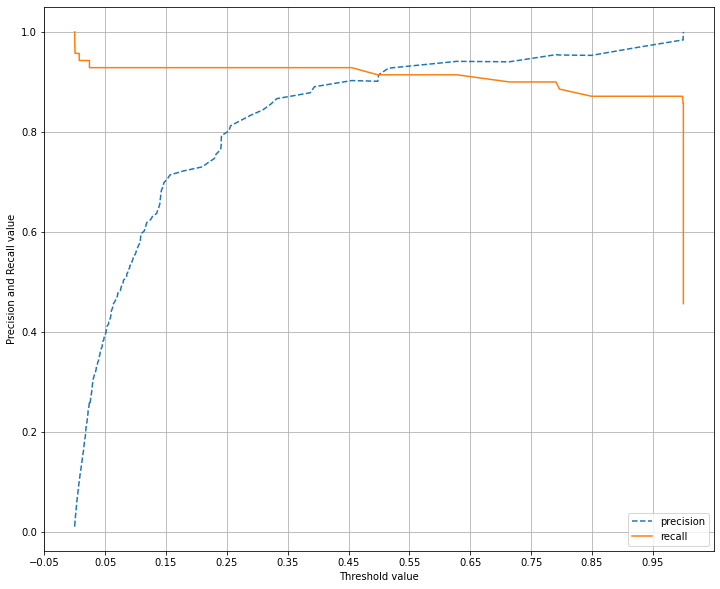

In [99]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve, roc_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    plt.figure(figsize=(12,10))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')

    plt.legend(loc='best')
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test,lr_pred_proba)

위 그래프를 보면 임계치는 약 0.5에서 가장 합리적인 값을 갖기에 따로 임계치를 조정할 필요는 없어 보인다

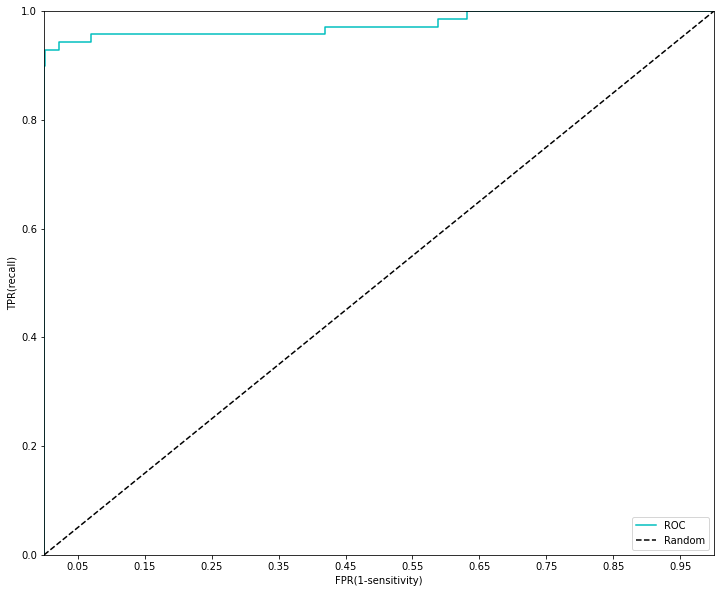

In [123]:
def roc_curve_plot(y_test,pred_proba_c1):
    fprs,tprs,thresholds=roc_curve(y_test,pred_proba_c1)
    plt.figure(figsize=(12,10))
    plt.plot(fprs,tprs,label='ROC',color='c')
    
    # [0,1],[0,1]은 x축에 0,1 y축에 0,1 => (0,0)과 (1,1)이은 직선!
    plt.plot([0,1],[0,1],'k--',label='Random')

    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend(loc='best')
    plt.show()

roc_curve_plot(y_test,lr_pred_proba)

## 결론

1. 타겟 데이터의 분포 확인 후, 아무런 엔지니어링 없이 1차적으로 로지스틱 회귀분석을 통해 성능 확인


2. 변수간 상관관계와 변수별 분포를 시각화하여 EDA진행


3. 로그변환을 통해 정규화하려 했으나 이미 데이터들이 모여있기도 했고, 로그변환 전이 더 종모양에 가까워 이 부분은 생략


4. 상관성이 높은 열 기준으로 이상치를 제거함. 음의 상관성을 가졌기에 일반거래 중 1사분위수보다 1.5IQR 만큼 낮은 행 데이터와 사기거래 중 3사분위수보다 1.5IQR 만큼 높은 행 데이터를 이상치라고 규정함. 이 부분에서 상관성이 높은 열이 3개 있었는데 각 열의 이상치 인덱스를 구한 후, 그 교집합에 해당하는 인덱스 집합을 만듦. 성능의 변화를 보며 재현율과 f1, roc-auc score를 가장 높일 수 있는 이상치 제거 인덱스 조합을 찾아 이상치 행 데이터를 제거함.


5. 이후 SMOTE오버 샘플링을 통해 사기 데이터를 증식해주었고, sampling_strategy 옵션을 Class=0과 Class=1의 비율을 100:5으로 맞추었을 때 가장 성능이 좋게 나와 이 비율을 선택함.


6. 재현율과 정밀도를 시각화하여 최적의 임계치로 바꿔주려했으나 최적의 임계치가 0.5에 가까워 그대로 두었고, roc곡선을 시각화해봄. 


7. 추가적으로 GridSearchCV를 통해 로지스틱 회귀의 규제 종류와 규제 정도 관련 최적의 파라미터를 구하려 했으나 이미 성능이 높아 규제로 인해 오히려 성능이 저하되어 이 부분은 삭제하였음.